In [32]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import glob
from pathlib import Path

In [4]:
data_dir = Path('/kaggle/input/chest-xray-pneumonia/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

In [6]:
# Check out the training data
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for image in normal_cases:
    train_data.append((image, 0))
    
for image in pneumonia_cases:
    train_data.append((image, 1))
    
train_df = pd.DataFrame(train_data, columns=['image_path', 'label']).sample(frac=1.).reset_index(drop=True)
train_df.shape

(5216, 2)

In [7]:
len(train_df.query('label == 0')), len(train_df.query('label == 1'))

(1341, 3875)

In [8]:
train_df['label'].value_counts()

label
1    3875
0    1341
Name: count, dtype: int64

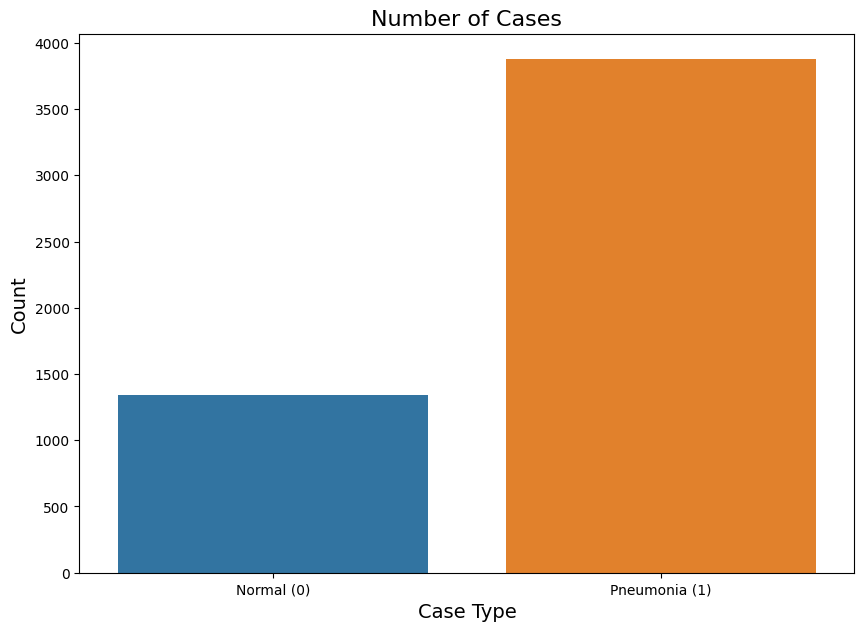

In [16]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(data=train_df, x='label')
ax.set_xticklabels(['Normal (0)', 'Pneumonia (1)'])
plt.xlabel('Case Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Number of Cases', fontsize=16)
plt.show()

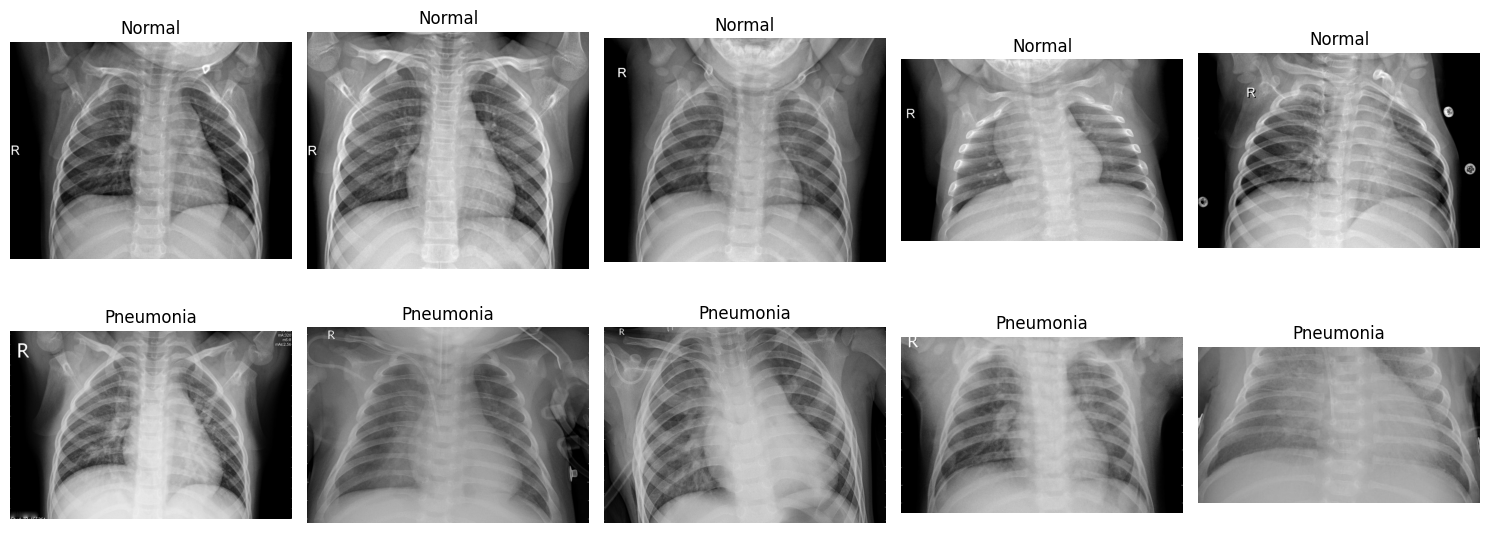

In [19]:
normal_samples = train_df.query('label == 0')['image_path'][:5].tolist()
pneumonia_samples = train_df.query('label == 1')['image_path'][:5].tolist()

samples = normal_samples + pneumonia_samples

labels = ['Normal'] * 5 + ['Pneumonia'] * 5

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, (image_path, label) in enumerate(zip(samples, labels)):
    img = Image.open(image_path)
    
    axs[i // 5, i % 5].imshow(img, cmap='gray')
    axs[i // 5, i % 5].set_title(label)
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

In [22]:
class PneumoniaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        super().__init__()
        self.data = ImageFolder(root=data_dir, 
                                transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [103]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=(1.2, 1.5)),
            transforms.ToTensor(),
        ])

In [105]:
train_data = PneumoniaDataset(data_dir=train_dir, transform=transform)
img, label = train_data[0]

In [107]:
img.shape

torch.Size([3, 224, 224])

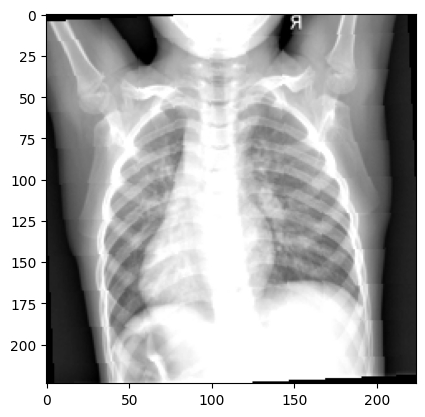

In [109]:
plt.imshow(img.permute(1, 2, 0))